In [1]:
from math import isnan
from functools import total_ordering
import calendar
import zipfile
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('MSFT.csv', sep=",").filter(['UnderlyingPrice', 'Type', 'Expiration',
                   'DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume', 'OpenInterest', 'IV', 'Delta', 'Gamma',
                   'Theta', 'Vega'])

In [3]:
data['Expiration'] = pd.to_datetime(data['Expiration'])
data['DataDate'] = pd.to_datetime(data['DataDate'])

In [4]:
df_call = data.loc[data['Type'] == "call"]

In [5]:
full_greeks = pd.read_csv('theta_call.csv')

,Unnamed: 0,Delta,Gamma,Theta,Vega,Count
0,1,0.508513,0.293932,-460.915591,1.769199,263
1,2,0.492150,0.221183,-163.152034,3.608902,266
2,3,0.502094,0.183372,-115.041570,4.796059,267
3,4,0.495077,0.159783,-93.496116,5.726578,235
4,7,0.499228,0.141272,-54.689635,7.890814,262
5,8,0.505683,0.117421,-54.391360,8.525506,263
6,9,0.496934,0.110682,-51.659346,9.112537,266
7,10,0.502108,0.104470,-48.911450,9.652437,267
8,11,0.499097,0.099522,-46.533618,10.129639,235
9,14,0.498810,0.094503,-37.669044,11.452535,261


In [8]:
def select_closest_dn_option_max_expiration_days(df):
    df['Days'] = (df['Expiration'] - df['DataDate']).astype('timedelta64[D]').astype(int)
    df2 = df.groupby('DataDate').apply(lambda x: x.groupby('Days').apply(lambda g: g.iloc[(g['Delta'] - 0.5).abs().argsort()[:1]]))
    max_expiration_days = df2.loc[df2['Days'].idxmax()]['Days']
    print(f'Max days option expiration is {max_expiration_days}')
    return df2

In [9]:
df_days = select_closest_dn_option_max_expiration_days(df_call)

Max days option expiration is 945


In [29]:
df_days

UnderlyingPrice  Type Expiration   DataDate  Strike  \
DataDate   Days                                                                
2016-11-01 3    42                 59.80  call 2016-11-04 2016-11-01    60.0   
           10   124                59.80  call 2016-11-11 2016-11-01    60.0   
           17   224                59.80  call 2016-11-18 2016-11-01    59.5   
           24   308                59.80  call 2016-11-25 2016-11-01    59.5   
           31   380                59.80  call 2016-12-02 2016-11-01    59.5   
...                                  ...   ...        ...        ...     ...   
2021-12-31 259  1714422           336.32  call 2022-09-16 2021-12-31   345.0   
           385  1714574           336.32  call 2023-01-20 2021-12-31   350.0   
           441  1714724           336.32  call 2023-03-17 2021-12-31   355.0   
           532  1714870           336.32  call 2023-06-16 2021-12-31   355.0   
           749  1715008           336.32  call 2024-01-19 2021-12-31   365.0   

                          Last    Bid    Ask  Volume  OpenInterest      IV  \
DataDate   Days                                                              
2016-11-01 3    42        0.37   0.31   0.37    8134          4904  0.2256   
           10   124       0.81   0.76   0.84     878          1959  0.2329   
           17   224       0.95   1.12   1.16     453           339  0.2137   
           24   308       1.53   1.17   1.23       0           616  0.1932   
           31   380       1.15   1.28   1.35       4            39  0.1880   
...                        ...    ...    ...     ...           ...     ...   
2021-12-31 259  1714422  27.20  26.25  29.00      57           755  0.2785   
           385  1714574  32.75  30.25  34.00     181          4765  0.2756   
           441  1714724  30.00  31.05  35.00       0          1095  0.2755   
           532  1714870  38.40  36.55  39.75       5          1498  0.2821   
           749  1715008  47.70  41.00  45.50       0           274  0.2827   

                          Delta   Gamma    Theta      Vega  Days  
DataDate   Days                                                   
2016-11-01 3    42       0.4314  0.3644 -33.3893    1.8792     3  
           10   124      0.4742  0.1788 -17.5871    3.8069    10  
           17   224      0.5265  0.1467  -9.9672    5.0176    17  
           24   308      0.5185  0.1358  -7.2651    5.9981    24  
           31   380      0.5154  0.1224  -6.2155    6.8375    31  
...                         ...     ...      ...       ...   ...  
2021-12-31 259  1714422  0.5034  0.0051 -22.2149  112.7978   259  
           385  1714574  0.5003  0.0042 -18.0305  137.5554   385  
           441  1714724  0.4911  0.0039 -16.9910  147.3328   441  
           532  1714870  0.5067  0.0035 -15.8515  161.8596   532  
           749  1715008  0.5027  0.0029 -13.4048  192.1119   749  

[21442 rows x 16 columns]

In [105]:
def filter_portfolio(portfolio_list: list, date: datetime.datetime):
    removed = []
    for l in portfolio_list:
        if l[1]['Expiration'] == date:
            removed.append(l)

    for r in removed:
        portfolio_list.remove(r)

    # print(f"after remove {len(portfolio_list)}")
    return removed

def calculate_delta_port(portfolio_list: list):
    delta_total = 0
    for p in portfolio_list:
        delta_total = delta_total + p[1]['Delta']

    return delta_total

In [106]:
def should_execute(spot, expired_today):
    total_minus = 0
    executed = 0
    for option in expired_today:
        strike = option[1]['Strike']
        if strike < spot:
            minus = strike - spot
            #print(f"option will be executed. Pay ${minus}")
            executed = executed + 1
            total_minus = total_minus + minus

    total_len = len(expired_today)
    if total_len > 0:
        print(f"From {total_len} expired options only {executed} were executed. Total minus {total_minus}")
    return total_minus

def visualize_balance(b):
    lists = sorted(b.items())
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.show()

Next date 2016-11-01 00:00:00
Next date 2016-11-02 00:00:00
Next date 2016-11-03 00:00:00
Next date 2016-11-04 00:00:00
From 1 expired options only 0 were executed. Total minus 0
Next date 2016-11-07 00:00:00
Next date 2016-11-08 00:00:00
Next date 2016-11-09 00:00:00
Next date 2016-11-10 00:00:00
Next date 2016-11-11 00:00:00
From 2 expired options only 1 were executed. Total minus -0.020000000000003126
Next date 2016-11-14 00:00:00
Next date 2016-11-15 00:00:00
Next date 2016-11-16 00:00:00
Next date 2016-11-17 00:00:00
Next date 2016-11-18 00:00:00
From 2 expired options only 2 were executed. Total minus -2.200000000000003
Next date 2016-11-21 00:00:00
Next date 2016-11-22 00:00:00
Next date 2016-11-23 00:00:00
Next date 2016-11-25 00:00:00
From 2 expired options only 2 were executed. Total minus -1.0600000000000023
Next date 2016-11-28 00:00:00
Next date 2016-11-29 00:00:00
Next date 2016-11-30 00:00:00


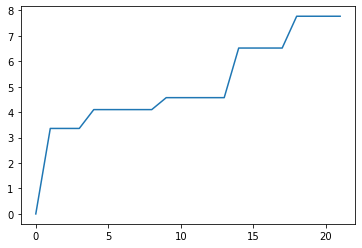

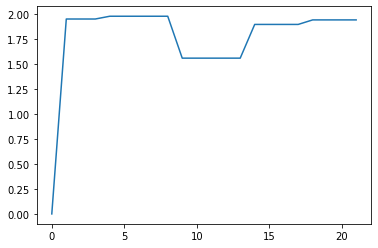

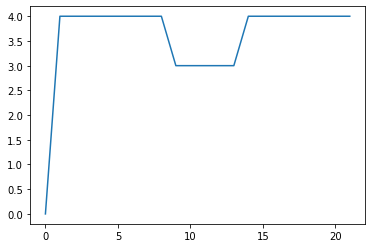

In [114]:
balance = {0: .0}
delta_port = {0: .0}
option_number = {0: 0}
min_expiration = 0
max_expiration = 25
max_days = 200


portfolio = []

max_delta = 2


current_date = datetime.datetime.now()
i = 0
for row in df_days.iterrows():
    if i > max_days:
        break

    date = row[1]['DataDate']
    if date != current_date:
        print(f'Next date {date}')
        current_date = date
        i = i + 1
        balance[i] = balance[i - 1]
        delta_port[i] = delta_port[i - 1]
        option_number[i] = option_number[i - 1]
        # delta = 0
        # print(f" number of options in port {len(portfolio)}")
        # for p in portfolio:
        #     delta = delta + p[1]['Delta']
        # delta_port[i] = delta

        # execute current options
        spot = row[1]['UnderlyingPrice']
        expired_today = filter_portfolio(portfolio, date)

        delta_port[i] = delta_port[i] - calculate_delta_port(expired_today)
        option_number[i] = option_number[i] - len(expired_today)
        should_execute(spot, expired_today)

    days = row[1]['Days']
    if days > max_expiration or days < 1:
        continue

    delta = row[1]['Delta']
    new_delta = delta_port[i] + delta
    if max_delta < new_delta:
        continue

    delta_port[i] = new_delta
    bid = row[1]['Bid']
    balance[i] = balance[i] + bid
    option_number[i] = option_number[i] + 1

    portfolio.append(row)

#print(balance)
visualize_balance(balance)
visualize_balance(delta_port)
visualize_balance(option_number)